In [1]:
#@title 🏙 TensorFlow Series <br/> Header Styling
import random; from IPython.display import display,HTML
from IPython.core.magic import register_line_magic
@register_line_magic
def decor_header(params):
    params=params.split('|'); string=params[0]
    if len(params)==1: 
        font_size='24'; font_family='Wallpoet'; cmap='Sinebow'
    elif  len(params)==2: 
        font_size=params[1]; font_family='Wallpoet'; cmap='Sinebow'
    elif  len(params)==3: 
        font_size=params[1]; font_family=params[2]; cmap='Sinebow'
    else: 
        font_size=params[1]; font_family=params[2]; cmap=params[3]
    height=max([int(font_size)*2.5,60]) 
    html_str="""
<script src='https://d3js.org/d3.v6.min.js'></script>
<style>
@import 'https://fonts.googleapis.com/css?family="""+font_family+"""';
#colorized001 {
font-family:"""+font_family+"""; font-size:"""+font_size+""";}
#canvas001,#canvas002 {width:10%; vertical-align:middle;}
</style>
<text id='colorized001'><canvas id='canvas001'></canvas>
"""+string+"""
<canvas id='canvas002'></canvas></text><br/>
<script>
var tc=setInterval(function() {
    var now=(new Date().getTime()%5000)/5000;
    var now_slow=(new Date().getTime()%100000)/100000;
    var iddoc=document.getElementById('colorized001');
    iddoc.style.color=d3.interpolate"""+cmap+"""(now);
    var r=10,n=7;
    var c1=document.getElementById('canvas001'); 
    var context1=c1.getContext('2d');
    var c2=document.getElementById('canvas002'); 
    var context2=c2.getContext('2d');
    c1.style.background=d3.interpolate"""+cmap+"""(now_slow); 
    c2.style.background=d3.interpolate"""+cmap+"""(now_slow);
    context1.strokeStyle=d3.interpolate"""+cmap+"""(now);    
    context2.strokeStyle=d3.interpolate"""+cmap+"""(now);
    for (var i=1; i<n; i++) {
        context1.beginPath(); context2.beginPath();
        for (var j=0; j<6; j++) {
            context1.arc(60*j,r*(n+.5),i*r,0,2*Math.PI);
            context2.arc(60*j,r*(n+.5),i*r,0,2*Math.PI); };
        context1.stroke(); context2.stroke(); }; },1)
</script>"""
    display(HTML(html_str))

In [2]:
%decor_header Modules, Helpful Functions, & Styling

In [3]:
import warnings; warnings.filterwarnings('ignore')
from IPython.display import display,HTML,Javascript,Image
from IPython.core.magic import register_line_magic
from google.colab import output
import numpy as np,pandas as pd,pylab as pl
import tensorflow_hub as th,tensorflow as tf
import seaborn as sn,h5py,urllib,PIL.Image
from sklearn.model_selection import train_test_split
import tensorflow.keras.callbacks as tkc,\
tensorflow.keras.layers as tkl
data_path='https://raw.githubusercontent.com/'+\
          'OlgaBelitskaya/data_kitchen/main/'
file_path='https://olgabelitskaya.gitlab.io/data/'
tfhub_path='https://tfhub.dev/google/magenta/'+\
           'arbitrary-image-stylization-v1-256/1'
mw='/checkpoints'

In [4]:
def pretty_print(string):
    js_str="""
var out1=document.querySelector('#output-area'),
    text1=document.createElement('text'),
    str1='"""+string+"""';
text1.appendChild(document.createTextNode(str1));
out1.appendChild(text1); 
text1.id='text1'; text1.style.padding='20px'; 
out1.style.border='double'; out1.style.width='50%';
var tc=setInterval(function() {
  var doc=document.getElementById('text1');
  var sec=Math.floor(new Date().getTime()%60000/1000);
  var col='rgb(0,'+(5+Math.abs(245-8*sec))+','+
          (250-Math.abs(245-8*sec))+')';
  doc.style.color=col;}, 1000);  
"""
    display(Javascript(js_str))
def df_style():
    pth=[('font-size','12pt'),('min-width','150px'),('height','25px')]
    ptd=[('padding','0em 0em'),('min-width','150px')]
    phth=[('font-size','14pt'),('max-width','150px'),
          ('text-shadow','3px 3px 3px #aaa')]
    phtd=[('font-size','12pt'),('max-width','150px'),
          ('text-shadow','3px 3px 3px #aaa')]
    return [{'props':pth,'selector':'th'},{'props':ptd,'selector':'td'},
            {'props':phth,'selector':'tr:hover th:hover'},
            {'props':phtd,'selector':'tr:hover td:hover'}]
def prepro(x_train,y_train,x_test,y_test):
    n=int(len(x_test)/2)
    x_valid,y_valid=x_test[:n],y_test[:n]
    x_test,y_test=x_test[n:],y_test[n:]
    df=pd.DataFrame([[x_train.shape,x_valid.shape,x_test.shape],
                     [y_train.shape,y_valid.shape,y_test.shape]],
                    columns=['train','valid','test'],
                    index=['images','labels'])
    display(df.style.set_table_styles(df_style()))
    return [[x_train,x_valid,x_test],[y_train,y_valid,y_test]]  

In [5]:
def get_file(file_name,folder_path,file_path=file_path):
    input_file=urllib.request.urlopen(
        file_path+folder_path+file_name)
    output_file=open(file_name,'wb'); 
    output_file.write(input_file.read())
    output_file.close(); input_file.close()
def load_img(path_to_img,max_dim=512):
    img=tf.io.read_file(path_to_img)
    img=tf.image.decode_image(img,channels=3)
    img=tf.image.convert_image_dtype(img,tf.float32)
    shape=tf.cast(tf.shape(img)[:-1],tf.float32)
    scale=max_dim/max(shape)
    new_shape=tf.cast(shape*scale,tf.int32)
    img=tf.image.resize(img,new_shape)
    return img[tf.newaxis,:]
def tensor_to_image(tensor):
    tensor=np.clip(tensor*255,0,255)
    tensor=np.array(tensor,dtype=np.uint8)
    if np.ndim(tensor)>3:
        assert tensor.shape[0]==1; tensor=tensor[0]
    return PIL.Image.fromarray(tensor)

In [6]:
def cb(mw):
    early_stopping=tkc.EarlyStopping(
        monitor='val_loss',patience=20,verbose=2)
    checkpointer=tkc.ModelCheckpoint(
        filepath=mw,verbose=0,save_weights_only=True,
        save_best_only=True,monitor='val_accuracy',mode='max')
    lr_reduction=tkc.ReduceLROnPlateau(
        monitor='val_loss',verbose=2,patience=5,factor=.8)
    return [checkpointer,early_stopping,lr_reduction]

In [7]:
%decor_header Data Loading & Preprocessing

In [8]:
get_file('Flowers128.h5','',data_path)
with h5py.File('Flowers128.h5','r') as f:
    keys=list(f.keys())
    pretty_print('h5py.File keys: '+', '.join(keys))
    images=np.array(f[keys[0]])
    labels=np.array(f[keys[1]],dtype='float32')
    names=[el.decode('utf-8') for el in f[keys[2]]]
    f.close()

<IPython.core.display.Javascript object>

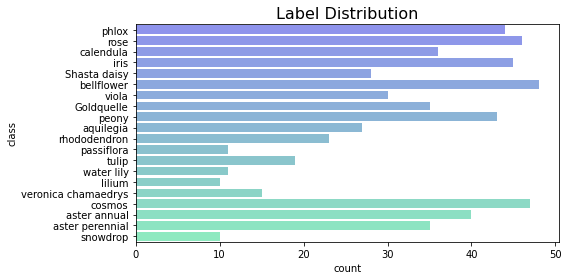

In [9]:
df=pd.DataFrame(labels,columns=['label'])
df['class']=[names[int(l)] for l in labels]
pl.figure(figsize=(8,4)); ti='Label Distribution'
sn.countplot(y='class',data=df,palette='winter',alpha=.5)
pl.title(ti,fontsize=16); pl.tight_layout(); pl.show()

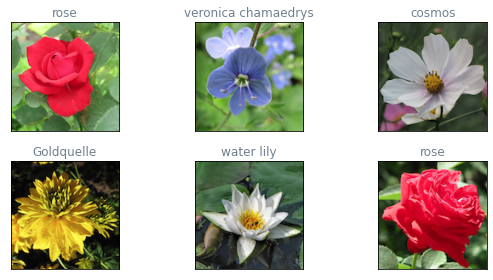

,train,valid,test
image shape,"(483, 128, 128, 3)","(60, 128, 128, 3)","(60, 128, 128, 3)"
image type,float32,float32,float32
label shape,"(483,)","(60,)","(60,)"
label type,float32,float32,float32


In [10]:
N=labels.shape[0]; n=int(.1*N); shuffle_ids=np.arange(N)
np.random.RandomState(12).shuffle(shuffle_ids)
images=images[shuffle_ids]; labels=labels[shuffle_ids]
x_test,x_valid,x_train=images[:n],images[n:2*n],images[2*n:]
y_test,y_valid,y_train=labels[:n],labels[n:2*n],labels[2*n:]
df=pd.DataFrame(
    [[x_train.shape,x_valid.shape,x_test.shape],
     [x_train.dtype,x_valid.dtype,x_test.dtype],
     [y_train.shape,y_valid.shape,y_test.shape],
     [y_train.dtype,y_valid.dtype,y_test.dtype]],
    columns=['train','valid','test'],
    index=['image shape','image type','label shape','label type'])
fig=pl.figure(figsize=(8,4)); randi=np.random.randint(1,100)
for i in range(randi,randi+6):
    ax=fig.add_subplot(2,3,i-randi+1,xticks=[],yticks=[])
    ax.set_title(names[int(labels[i])],color='slategray',
                 fontdict={'fontsize':'large'})
    ax.imshow((images[i]))
pl.tight_layout(); pl.show()
display(df.style.set_table_styles(df_style()))

In [11]:
(x_train2,y_train2),(x_test2,y_test2)=\
tf.keras.datasets.cifar10.load_data()
[[x_train2,x_valid2,x_test2],
 [y_train2,y_valid2,y_test2]]=\
prepro(x_train2,y_train2,x_test2,y_test2)

170500096/170498071 [==============================] - 4s 0us/step


,train,valid,test
images,"(50000, 32, 32, 3)","(5000, 32, 32, 3)","(5000, 32, 32, 3)"
labels,"(50000, 1)","(5000, 1)","(5000, 1)"


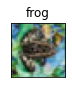

In [12]:
cifar_labels=['airplane','automobile','bird','cat','deer',
              'dog','frog','horse','ship','truck']
pl.figure(figsize=(1,1)) 
pl.xticks([]); pl.yticks([])
pl.title(cifar_labels[y_train2[200][0]])
pl.imshow(x_train2[200]);

In [13]:
%decor_header Fast Examples Of Neural Networks

40960/35363 [==================================] - 0s 0us/step
['palace', 0.25933808]
['geyser', 0.24141519]
['fountain', 0.22272643]
['lakeside', 0.06970484]
['castle', 0.06321851]


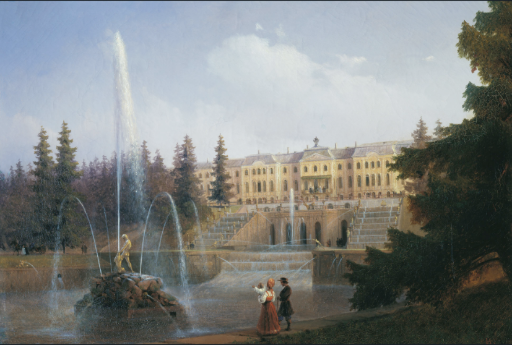

In [14]:
get_file('01_00_002.png','paintings/')
content_image=load_img('01_00_002.png')
x=tf.keras.applications.vgg19\
.preprocess_input(content_image*255)
x=tf.image.resize(x,(224,224))
vgg19=tf.keras.applications\
.VGG19(include_top=True,weights='imagenet')
prediction_probabilities=vgg19(x)
predicted_top5=tf.keras.applications.vgg19\
.decode_predictions(prediction_probabilities.numpy())[0]
[print([class_name,prob]) for (number,class_name,prob) in predicted_top5]
tensor_to_image(content_image)

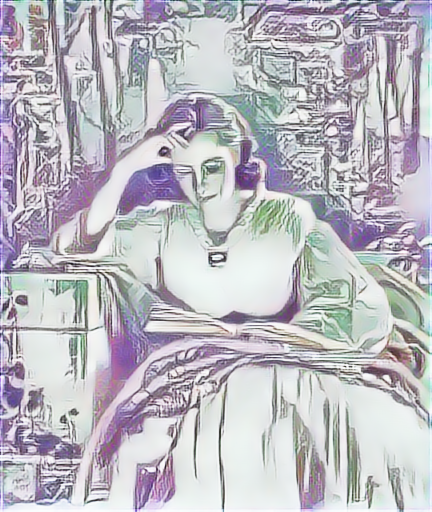

In [15]:
hub_module=th.load(tfhub_path)
get_file('00_03_002.png','paintings/')
get_file('00_00_001.png','patterns/')
content_image=load_img('00_03_002.png')
style_image=load_img('00_00_001.png')
stylized_image=hub_module(
    tf.constant(content_image),tf.constant(style_image))[0]
tensor_to_image(stylized_image)

In [16]:
%decor_header Some Variants Of Keras Models

In [17]:
def mlp_model(img_size,num_classes):
    model=tf.keras.models.Sequential([
        tkl.Flatten(input_shape=(img_size,img_size,3)),
        tkl.Dense(128,activation='relu'),
        tkl.BatchNormalization(),    
        tkl.Dense(256,activation='relu'),
        tkl.BatchNormalization(),    
        tkl.Dense(512,activation='relu'),
        tkl.BatchNormalization(),   
        tkl.Dense(1024,activation='relu'),
        tkl.Dropout(.2),
        tkl.Dense(num_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    return model

In [18]:
model=mlp_model(128,20)
model.fit(x_train,y_train,epochs=100,batch_size=16,
          callbacks=cb(mw),validation_data=(x_valid,y_valid));

Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 3.0904 - accuracy: 0.1403 - val_loss: 13.6709 - val_accuracy: 0.1000
Epoch 2/100
31/31 [==============================] - 0s 7ms/step - loss: 2.0235 - accuracy: 0.3773 - val_loss: 5.6137 - val_accuracy: 0.0833
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 1.6536 - accuracy: 0.4989 - val_loss: 5.6160 - val_accuracy: 0.1167
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 1.1748 - accuracy: 0.6162 - val_loss: 4.0968 - val_accuracy: 0.1333
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.7918 - accuracy: 0.7688 - val_loss: 3.9305 - val_accuracy: 0.1333
Epoch 6/100
31/31 [==============================] - 0s 7ms/step - loss: 0.6609 - accuracy: 0.7945 - val_loss: 4.6845 - val_accuracy: 0.2333
Epoch 7/100
31/31 [==============================] - 0s 8ms/step - loss: 0.6547 - accuracy: 0.8029 - val_loss: 3.4671 - val_accuracy: 0.3000
Epoch 8/100

In [19]:
model.load_weights(mw)
pretty_print(str(model.evaluate(x_test,y_test,verbose=0)))

<IPython.core.display.Javascript object>

In [20]:
model=mlp_model(32,10)
model.fit(x_train2,y_train2,epochs=100,batch_size=16,
          validation_data=(x_valid2,y_valid2),callbacks=cb(mw))

Epoch 1/100
3125/3125 [==============================] - 10s 3ms/step - loss: 2.1528 - accuracy: 0.2911 - val_loss: 2.3908 - val_accuracy: 0.3148
Epoch 2/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.7123 - accuracy: 0.3920 - val_loss: 1.8970 - val_accuracy: 0.3756
Epoch 3/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.6560 - accuracy: 0.4127 - val_loss: 2.0299 - val_accuracy: 0.3678
Epoch 4/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.6127 - accuracy: 0.4265 - val_loss: 1.5647 - val_accuracy: 0.4606
Epoch 5/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.5795 - accuracy: 0.4386 - val_loss: 1.9910 - val_accuracy: 0.4240
Epoch 6/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.5395 - accuracy: 0.4544 - val_loss: 2.5882 - val_accuracy: 0.4732
Epoch 7/100
3125/3125 [==============================] - 9s 3ms/step - loss: 1.5008 - accuracy: 0.4667 - val_loss: 1.5698 - val_a

In [21]:
model.load_weights(mw)
pretty_print(str(model.evaluate(x_test2,y_test2,verbose=0)))

<IPython.core.display.Javascript object>

In [22]:
def cnn_model(img_size,num_classes):
    model=tf.keras.models.Sequential([
        tkl.Conv2D(32,(5,5),padding='same',
            input_shape=(img_size,img_size,3)),
        tkl.Activation('relu'),
        tkl.MaxPooling2D(pool_size=(2,2)),
        tkl.Dropout(.25),
        tkl.Conv2D(196,(5,5)),
        tkl.Activation('relu'),    
        tkl.MaxPooling2D(pool_size=(2,2)),
        tkl.Dropout(.25),
        tkl.GlobalAveragePooling2D(),    
        tkl.Dense(512),
        tkl.Activation('relu'),
        tkl.Dropout(.25),
        tkl.Dense(128),
        tkl.Activation('relu'),
        tkl.Dropout(.25),
        tkl.Dense(num_classes,activation='softmax')
    ])
    model.compile(optimizer='adam',metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy')
    return model

In [23]:
model=cnn_model(128,20)
model.fit(x_train,y_train,epochs=100,batch_size=64,
          validation_data=(x_valid,y_valid),callbacks=cb(mw))

Epoch 1/100
8/8 [==============================] - 3s 235ms/step - loss: 2.9832 - accuracy: 0.0431 - val_loss: 2.9751 - val_accuracy: 0.1000
Epoch 2/100
8/8 [==============================] - 0s 62ms/step - loss: 2.8904 - accuracy: 0.0817 - val_loss: 2.9503 - val_accuracy: 0.1167
Epoch 3/100
8/8 [==============================] - 0s 62ms/step - loss: 2.8293 - accuracy: 0.1644 - val_loss: 2.8799 - val_accuracy: 0.1667
Epoch 4/100
8/8 [==============================] - 1s 63ms/step - loss: 2.7295 - accuracy: 0.1512 - val_loss: 2.7132 - val_accuracy: 0.2000
Epoch 5/100
8/8 [==============================] - 0s 63ms/step - loss: 2.5729 - accuracy: 0.1981 - val_loss: 2.5284 - val_accuracy: 0.2500
Epoch 6/100
8/8 [==============================] - 0s 63ms/step - loss: 2.4656 - accuracy: 0.2007 - val_loss: 2.4183 - val_accuracy: 0.2833
Epoch 7/100
8/8 [==============================] - 1s 65ms/step - loss: 2.3845 - accuracy: 0.2401 - val_loss: 2.3740 - val_accuracy: 0.2667
Epoch 8/100
8/8 [==

In [24]:
model.load_weights(mw)
pretty_print(str(model.evaluate(x_test,y_test,verbose=0)))

<IPython.core.display.Javascript object>

In [25]:
model=cnn_model(32,10)
model.fit(x_train2,y_train2,epochs=100,batch_size=64,
          validation_data=(x_valid2,y_valid2),callbacks=cb(mw))

Epoch 1/100
782/782 [==============================] - 5s 5ms/step - loss: 2.7588 - accuracy: 0.2127 - val_loss: 1.7175 - val_accuracy: 0.3830
Epoch 2/100
782/782 [==============================] - 4s 5ms/step - loss: 1.6445 - accuracy: 0.3944 - val_loss: 1.3783 - val_accuracy: 0.5126
Epoch 3/100
782/782 [==============================] - 4s 5ms/step - loss: 1.4703 - accuracy: 0.4668 - val_loss: 1.3287 - val_accuracy: 0.5162
Epoch 4/100
782/782 [==============================] - 4s 5ms/step - loss: 1.3826 - accuracy: 0.5017 - val_loss: 1.2781 - val_accuracy: 0.5574
Epoch 5/100
782/782 [==============================] - 4s 5ms/step - loss: 1.3127 - accuracy: 0.5335 - val_loss: 1.2858 - val_accuracy: 0.5370
Epoch 6/100
782/782 [==============================] - 4s 5ms/step - loss: 1.2629 - accuracy: 0.5509 - val_loss: 1.1948 - val_accuracy: 0.5750
Epoch 7/100
782/782 [==============================] - 4s 5ms/step - loss: 1.2103 - accuracy: 0.5715 - val_loss: 1.0824 - val_accuracy: 0.6298

In [26]:
model.load_weights(mw)
pretty_print(str(model.evaluate(x_test2,y_test2,verbose=0)))

<IPython.core.display.Javascript object>

In [27]:
def rnn_model(img_size,hidden,num_classes):
    model=tf.keras.models.Sequential([
        tkl.BatchNormalization(
            input_shape=(1,3*img_size**2)),
        tkl.LSTM(hidden,return_sequences=True),
        tkl.LSTM(hidden,return_sequences=True),
        tkl.LSTM(hidden),
        tkl.BatchNormalization(),     
        tkl.Dense(num_classes,activation='softmax')
    ])
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam',metrics=['accuracy'])    
    return model 

In [28]:
model=rnn_model(128,256,20)
model.fit(x_train.reshape(-1,1,128*128*3),y_train,
          epochs=100,batch_size=128,callbacks=cb(mw),
          validation_data=(x_valid.reshape(-1,1,128*128*3),y_valid))

Epoch 1/100
4/4 [==============================] - 5s 415ms/step - loss: 2.7499 - accuracy: 0.1679 - val_loss: 2.9782 - val_accuracy: 0.0500
Epoch 2/100
4/4 [==============================] - 0s 67ms/step - loss: 1.5065 - accuracy: 0.5994 - val_loss: 2.9592 - val_accuracy: 0.0833
Epoch 3/100
4/4 [==============================] - 0s 68ms/step - loss: 0.9618 - accuracy: 0.7784 - val_loss: 2.9451 - val_accuracy: 0.1333
Epoch 4/100
4/4 [==============================] - 0s 65ms/step - loss: 0.6372 - accuracy: 0.8551 - val_loss: 2.9394 - val_accuracy: 0.1333
Epoch 5/100
4/4 [==============================] - 0s 57ms/step - loss: 0.4360 - accuracy: 0.9315 - val_loss: 2.9292 - val_accuracy: 0.1500
Epoch 6/100
4/4 [==============================] - 0s 67ms/step - loss: 0.2670 - accuracy: 0.9553 - val_loss: 2.9247 - val_accuracy: 0.1500
Epoch 7/100
4/4 [==============================] - 0s 58ms/step - loss: 0.1536 - accuracy: 0.9765 - val_loss: 2.9220 - val_accuracy: 0.1333
Epoch 8/100
4/4 [==

In [29]:
model.load_weights(mw)
pretty_print(str(model.evaluate(
    x_test.reshape(-1,1,128*128*3),y_test,verbose=0)))

<IPython.core.display.Javascript object>

In [30]:
model=rnn_model(32,128,10)
model.fit(x_train2.reshape(-1,1,32*32*3),y_train2,
          epochs=50,batch_size=128,callbacks=cb(mw),
          validation_data=(x_valid2.reshape(-1,1,32*32*3),y_valid2))

Epoch 1/50
391/391 [==============================] - 7s 9ms/step - loss: 1.7806 - accuracy: 0.3589 - val_loss: 1.9653 - val_accuracy: 0.3986
Epoch 2/50
391/391 [==============================] - 3s 7ms/step - loss: 1.5606 - accuracy: 0.4409 - val_loss: 1.5491 - val_accuracy: 0.4436
Epoch 3/50
391/391 [==============================] - 3s 6ms/step - loss: 1.4915 - accuracy: 0.4642 - val_loss: 1.5036 - val_accuracy: 0.4690
Epoch 4/50
391/391 [==============================] - 3s 6ms/step - loss: 1.4484 - accuracy: 0.4816 - val_loss: 1.4967 - val_accuracy: 0.4728
Epoch 5/50
391/391 [==============================] - 3s 6ms/step - loss: 1.3885 - accuracy: 0.5038 - val_loss: 1.4969 - val_accuracy: 0.4728
Epoch 6/50
391/391 [==============================] - 3s 6ms/step - loss: 1.3591 - accuracy: 0.5142 - val_loss: 1.4614 - val_accuracy: 0.4784
Epoch 7/50
391/391 [==============================] - 3s 6ms/step - loss: 1.3257 - accuracy: 0.5268 - val_loss: 1.4514 - val_accuracy: 0.4880
Epoch 

In [31]:
model.load_weights(mw)
pretty_print(str(model.evaluate(
    x_test2.reshape(-1,1,32*32*3),y_test2,verbose=0)))

<IPython.core.display.Javascript object>